In [4]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import sklearn as sk 
import os 
import cv2
import glob
import time
import os
import albumentations as A
from PIL import Image 
from tensorflow import keras 
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix 

training_path = "/kaggle/input/sp-society-camera-model-identification/train/train/"
testing_path = "/kaggle/input/sp-society-camera-model-identification/test/test/"
_,training_classes,_=next(os.walk(training_path))
#print(training_classes)


In [5]:
batch_size = 8
epochs = 50
learning_rate = 1e-4

In [6]:
_,_,testing_files = next(os.walk(testing_path))
#testing_files

In [7]:
training_paths = [] 
labels = [] 
for i in training_classes:
    _,_,filenames = next(os.walk(training_path+i))
    for j in filenames:
        training_paths.append(training_path+i+'/'+j)
        labels.append(i)

In [8]:
assert len(training_paths)==len(labels)

In [9]:
seed = 33

In [10]:
np.unique(labels)

array(['HTC-1-M7', 'LG-Nexus-5x', 'Motorola-Droid-Maxx',
       'Motorola-Nexus-6', 'Motorola-X', 'Samsung-Galaxy-Note3',
       'Samsung-Galaxy-S4', 'Sony-NEX-7', 'iPhone-4s', 'iPhone-6'],
      dtype='<U20')

In [11]:
training_data = pd.DataFrame(training_paths,columns=['Training Image Path'])
classes = pd.DataFrame(labels)
print(classes)
classes = pd.get_dummies(classes)
classes.columns=np.unique(labels)# One Hot Encode the class variables

                      0
0     Samsung-Galaxy-S4
1     Samsung-Galaxy-S4
2     Samsung-Galaxy-S4
3     Samsung-Galaxy-S4
4     Samsung-Galaxy-S4
...                 ...
2745        LG-Nexus-5x
2746        LG-Nexus-5x
2747        LG-Nexus-5x
2748        LG-Nexus-5x
2749        LG-Nexus-5x

[2750 rows x 1 columns]


In [12]:
training_data

,Training Image Path
0,/kaggle/input/sp-society-camera-model-identifi...
1,/kaggle/input/sp-society-camera-model-identifi...
2,/kaggle/input/sp-society-camera-model-identifi...
3,/kaggle/input/sp-society-camera-model-identifi...
4,/kaggle/input/sp-society-camera-model-identifi...
...,...
2745,/kaggle/input/sp-society-camera-model-identifi...
2746,/kaggle/input/sp-society-camera-model-identifi...
2747,/kaggle/input/sp-society-camera-model-identifi...
2748,/kaggle/input/sp-society-camera-model-identifi...


In [13]:
classes.head()

,HTC-1-M7,LG-Nexus-5x,Motorola-Droid-Maxx,Motorola-Nexus-6,Motorola-X,Samsung-Galaxy-Note3,Samsung-Galaxy-S4,Sony-NEX-7,iPhone-4s,iPhone-6
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [14]:
classes_dict = {'0':'HTC-1-M7',
                '1':'LG-Nexus-5x',
                '2':'Motorola-Droid-Maxx',
                '3':'Motorola-Nexus-6',
                '4':'Motorola-X',
                '5':'Samsung-Galaxy-Note3',
                '6':'Samsung-Galaxy-S4',
                '7':'Sony-NEX-7',
                '8':'iPhone-4s',
                '9':'iPhone-6'}

In [15]:
testing_data = pd.DataFrame(testing_files,columns=['Testing Image Path'])
testing_data

,Testing Image Path
0,img_b551817_manip.tif
1,img_90bf577_unalt.tif
2,img_44c7044_unalt.tif
3,img_6481076_unalt.tif
4,img_6f87d1f_manip.tif
...,...
2635,img_f5c6b8e_unalt.tif
2636,img_a9da818_manip.tif
2637,img_53bbd9f_unalt.tif
2638,img_db8cb11_unalt.tif


In [16]:
def read_img(path):
    temp = cv2.imread(path)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    return temp

In [17]:
length = 512
training_transforms = A.Compose([A.RandomCrop(height=length,width=length),
                                A.RandomGamma(gamma_limit=(80,120),p=0.5),
                                A.JpegCompression(quality_lower=70,quality_upper=90,p=0.5)])
    

                                
testing_augmentation = A.Compose([
                                  A.CenterCrop(height=length,width=length)])

/opt/conda/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:967: FutureWarning: This class has been deprecated. Please use ImageCompression
  FutureWarning,


In [18]:
class Dataset(keras.utils.Sequence):
    def __init__(self,x,y,batch_size,augmentations,test):
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.augmentations = augmentations 
        self.test = test 
    def __len__(self):
        return int(len(self.x)/self.batch_size)
    def __getitem__(self,index):
        batched_x = self.x.iloc[index*self.batch_size:(index+1)*self.batch_size].to_numpy()
        if(self.test):
            images = [(self.augmentations(image=read_img(i))['image']) for i in batched_x]
            
        else:
            batched_y = self.y.iloc[index*self.batch_size : (index+1)*self.batch_size,:]
            images = [(self.augmentations(image=read_img(i[0]))['image']) for i in batched_x]
        return np.array(images)if self.test else (np.array(images),batched_y.values)

In [19]:
dummy_dataset = Dataset(training_data,classes,batch_size=batch_size,augmentations=training_transforms,test=False)

[[[129  93  85]
  [125  89  81]
  [118  82  74]
  ...
  [161 184 139]
  [176 200 152]
  [175 199 151]]

 [[150 114 106]
  [150 114 106]
  [152 116 108]
  ...
  [209 232 187]
  [212 236 188]
  [193 217 169]]

 [[172 136 128]
  [173 137 129]
  [180 144 136]
  ...
  [192 218 170]
  [180 206 158]
  [153 179 131]]

 ...

 [[189 237 231]
  [211 255 253]
  [201 252 245]
  ...
  [147 173 180]
  [148 174 181]
  [148 174 181]]

 [[179 225 219]
  [209 255 251]
  [195 246 239]
  ...
  [145 172 182]
  [146 173 183]
  [147 174 184]]

 [[166 212 206]
  [214 255 255]
  [210 255 252]
  ...
  [143 170 180]
  [143 170 180]
  [143 170 180]]]
(8, 512, 512, 3)
[[0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 1 0 0 0]]
(8, 10)


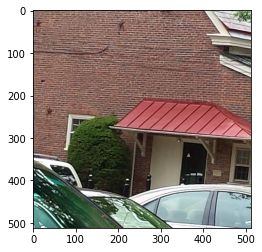

In [20]:
(a,b)=dummy_dataset.__getitem__(5)
print(a[0])
print(a.shape)
print(b)
print(b.shape)
plt.imshow(a[0])



In [21]:
def keras_model(length,input_size,output_classes):
        base_model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=[length, length, 3])
        base_model.trainable = True
        inputs =tf.keras.layers.Input(shape=(length,length,3))
        x = tf.keras.applications.densenet.preprocess_input(inputs)
        x = base_model(x, training=True)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        x = tf.keras.layers.Dense(64, activation='relu')(x)
        x = tf.keras.layers.Dense(32,activation='relu')(x)
        outputs = tf.keras.layers.Dense(10, activation='softmax')(x)
        model =tf.keras.Model(inputs=inputs, outputs=outputs)
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
        return model

In [22]:
training_model = keras_model(length,length*length*3,10)

2021-12-04 04:42:34.635250: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 04:42:34.713501: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 04:42:34.714217: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-04 04:42:34.715284: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

74850304/74836368 [==============================] - 1s 0us/step


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [23]:
training_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 512, 512, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 512, 512, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 512, 512, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 512, 512, 3)       0         
_________________________________________________________________
densenet201 (Functional)     (None, 16, 16, 1920)      18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                122944

In [24]:
xtrain,xval,ytrain,yval = train_test_split(training_data,classes,test_size=0.1,shuffle=True,random_state=seed)

In [25]:
print(len(xtrain),len(xval))
print(len(ytrain),len(yval))

2475 275
2475 275


In [26]:
training_dataset = Dataset(xtrain,ytrain,batch_size=batch_size,augmentations=training_transforms,test=False)
validation_dataset = Dataset(xval,yval,batch_size=1,augmentations=training_transforms,test=False)

print(len(training_dataset))
print(len(validation_dataset))

309
275


In [27]:
model_file = "output/base_model_weights.hd5"

checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, monitor="val_accuracy", save_best_only=True, mode='max')

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=0.9, patience=2, min_lr=1e-6, mode="max", verbose=True)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=5, mode="max", verbose=True)

callbacks_list = [checkpoint, reduce_lr, early_stopping]


In [ ]:
inner_epochs = 10
training_model.fit(training_dataset,validation_data=validation_dataset,epochs=inner_epochs,batch_size=batch_size,callbacks=callbacks_list,verbose=1)
loops = (epochs-inner_epochs)//inner_epochs
for i in range(0,loops):
    training_model= keras.models.load_model(model_file)
    training_model.fit(training_dataset,validation_data=validation_dataset,epochs=inner_epochs,batch_size=batch_size,callbacks=callbacks_list,verbose=1)

2021-12-04 04:42:44.648492: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/10


2021-12-04 04:43:03.186110: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


198/309 [==================>...........] - ETA: 3:16 - loss: 1.8070 - accuracy: 0.3794

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/sp-society-camera-model-identification/sample_submission.csv')
sample_submission.head()

In [ ]:
x_test = testing_path+sample_submission['fname']
#x_test = x_test.to_numpy()
print(x_test[0])

#training_model.load_model(model_file)
x_test = Dataset(x_test,x_test,test=True,batch_size=1,augmentations=testing_augmentation)

In [ ]:
val_predicted = training_model.predict(validation_dataset)
print(val_predicted)

In [ ]:
#training_model = tf.keras.models.load_model(model_file)
predicted = training_model.predict(x_test)

print(predicted)

In [ ]:
def convert_predictions_to_labels(labels):
    temp = []
    for item in labels.argmax(axis=1):
        temp.append(classes_dict[str(item)])
    return temp

In [ ]:
test_labels = convert_predictions_to_labels(predicted)

validation_labels = convert_predictions_to_labels(val_predicted)

In [ ]:
sample_submission['camera'] = test_labels
sample_submission.head()

In [ ]:
sample_submission.to_csv("submission.csv", index=False)

In [ ]:
yval.idxmax(axis=1)

In [ ]:
con_matrix = confusion_matrix(yval,validation_labels)
print(con_matrix)